<a href="https://colab.research.google.com/github/imceballos/udd_homeworks/blob/main/Tarea2_MLAplicado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h2>Modelos de lenguaje y clasificación de texto</h2>

Autor: Israel Ceballos

Profesor: Alonso Astroza

El objetivo de este trabajo es crear un clasificador de **reviews** en base a reseñas de **Amazon**

## *Instalación de libreria fastai*

In [ ]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 32.1MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
!pip install fastai-ulmfit

     |████████████████████████████████| 1.2MB 35.7MB/s 


In [ ]:
from fastai_ulmfit.pretrained import *
from fastai.text.all import *

Crearemos la carpeta data, esta nos servira pronto para almacenar la data 

In [ ]:
path = Path('data')
dest = path
dest.mkdir(parents=True, exist_ok=True)

## <h2>Autenticación y descarga en GCP </h2>

La información esta alojada en GCP (Google Cloud Platform), para poder acceder a ella debe logerarse con su cuenta alonsoastroza@gmail.com, esta cuenta tiene habilitado los permisos para acceder a descargar la infromación.

In [ ]:
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=LGTvZfey5JlMwJidiDt22ooVlc8rM7&prompt=consent&access_type=offline&code_challenge=KZbvofOZcvcua3X-SStBAiIIo0bXhu5Y8T-j-_Z8V7Y&code_challenge_method=S256

Enter verification code: 4/1AX4XfWgR5euCVsmA4cxtDgwMSKOEw5l3-bJOErXtMEGbhRGFAXZwckuRtLc

You are now logged in as [eliizabeth.fren@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


### <h3>Descargamos la información de dataset_es_train</h3>

In [ ]:
!gsutil cp -r  gs://tareaml2/dataset_es_train.json data/

Copying gs://tareaml2/dataset_es_train.json...
- [1 files][ 73.9 MiB/ 73.9 MiB]                                                
Operation completed over 1 objects/73.9 MiB.                                     


###<h3>Descargamos la información de dataset_es_test</h3>

In [ ]:
!gsutil cp -r gs://tareaml2/dataset_es_test.json data/

Copying gs://tareaml2/dataset_es_test.json...
/ [1 files][  1.8 MiB/  1.8 MiB]                                                
Operation completed over 1 objects/1.8 MiB.                                      


##<h2>Carga de los datos (Pregunta 2.1)</h2>

In [ ]:
import pandas as pd

Conjunto de entrenamiento

In [ ]:
df_train = pd.read_json('data/dataset_es_train.json', lines=True)
df_train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático, después de una hora fue capaz de instalarlo",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,"Te obligan a comprar dos unidades y te llega solo una y no hay forma de reclamar, una autentica estafa, no compreis!!",solo llega una unidad cuando te obligan a comprar dos,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo puedo decir que tras dos meses de espera.... sigo sin el producto y tuve que contactar con Amazon para reclamar su reembolso. Amazon un 10 . Se hace cargo del problema, pero yo e desembolsado mi dinero y en dos meses me lo devuelven Perdida de tiempo TOTAL. Sin palabras. Y Ustedes deciden",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


Conjunto de validación

In [ ]:
df_test = pd.read_json('data/dataset_es_test.json', lines=True)
df_test.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correos normal sin seguimiento y nunca me llego tota un desastre,no me llego,es,wireless
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,Estoy muy decepcionado con el vendedor ya que el pedido no me llegó a tiempo y no cumplió los plazos de envío y era una cosa que necesitaba urgente. Para colmo me pongo en contacto con el vendedor y no da señales. No recomiendo nada,ESTAFA EN EL ENVÍO,es,toy
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,"Mi valoración no es sobre el producto sino sobre AMAZON. Ofrecéis el producto a 299€ y tras varios días me devolvéis el dinero porque os habéis equivocado en el anuncio, según vosotros, ahora es 399€. Es la primera vez que me ocurre esto. Cuando he comprado en cualquier sitio y el precio marcado no se correspondía con el valor de caja siempre me lo han vendido con el precio marcado. Es inverosímil lo ocurrido, pero la ultima palabra me la dará la oficina del consumidor",Estafa de Amazon,es,home
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,Pues tenía interés en este libro y probé la versión kindle. se abre la portada pero nada más. parece una mala broma pero me iba a gastar el dedo de tanto tratar que pasara de página de alguna forma. No puedo valorar nada de nada.,No conseguí pasar de la portada en Kindle,es,digital_ebook_purchase


###<h3>Número de stars y largo de reseñas</h3>

Conjunto de entrenamiento

In [ ]:
df_train['stars'].value_counts()

5    40000
4    40000
3    40000
2    40000
1    40000
Name: stars, dtype: int64

In [ ]:
reviews_train = df_train[['stars', 'review_body']].apply(lambda x: [x['stars'], len(x['review_body'])], axis=1).tolist()
df_reviews_train = pd.DataFrame(reviews_train, columns=['stars','len_reviews'])

In [ ]:
df_reviews_train.groupby('stars').sum()

,len_reviews
stars,
1,6115339
2,6737550
3,6215212
4,5694288
5,5498193


Conjunto de validación

In [ ]:
df_test['stars'].value_counts()

3    1000
2    1000
5    1000
1    1000
4    1000
Name: stars, dtype: int64

In [ ]:
reviews_test = df_test[['stars', 'review_body']].apply(lambda x: [x['stars'], len(x['review_body'])], axis=1).tolist()
df_reviews_test = pd.DataFrame(reviews_test, columns=['stars','len_reviews'])

In [ ]:
df_reviews_test.groupby('stars').sum()

,len_reviews
stars,
1,156122
2,164685
3,155265
4,143903
5,139596


##<h2>Entrenamiento del modelo (Pregunta 2.2)</h2>

###<h3>Tratamiento de los datos</h3>

Para entrenar este modelo usaremos ULMFIT, el cual se encuentra disponible en la siguiente url:

In [ ]:
url = 'http://bit.ly/ulmfit-eswiki'
tok = tokenizer_from_pretrained(url)

Extraemos la información desde el *review_body* para aislarla en *df_lm_train*

In [ ]:
df_lm_train = df_train[['review_body']]
df_lm_train.head()

,review_body
0,Nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante
1,"Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático, después de una hora fue capaz de instalarlo"
2,"Te obligan a comprar dos unidades y te llega solo una y no hay forma de reclamar, una autentica estafa, no compreis!!"
3,"No entro en descalificar al vendedor, solo puedo decir que tras dos meses de espera.... sigo sin el producto y tuve que contactar con Amazon para reclamar su reembolso. Amazon un 10 . Se hace cargo del problema, pero yo e desembolsado mi dinero y en dos meses me lo devuelven Perdida de tiempo TOTAL. Sin palabras. Y Ustedes deciden"
4,Llega tarde y co la talla equivocada


In [ ]:
dblocks = DataBlock(blocks=(TextBlock.from_df('review_body', tok=tok, is_lm=True)),
                    get_x=ColReader('text'), 
                    splitter=RandomSplitter(0.1))

dls = dblocks.dataloaders(df_lm_train, bs=64, seq_len=80)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
learn = language_model_from_pretrained(dls, url=url, drop_mult=0.3, metrics = [accuracy, Perplexity()]).to_fp16()

SuggestedLRs(valley=tensor(0.0036))

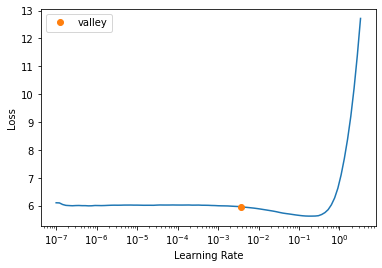

In [ ]:
learn.lr_find()

In [ ]:
lr = 8e-3

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.917564,3.838445,0.269934,46.453171,05:28


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(lr/100,lr), moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.729948,3.696817,0.283631,40.318764,05:35
1,3.610998,3.579109,0.296282,35.841606,05:35
2,3.487573,3.510746,0.304631,33.473213,05:36
3,3.364237,3.472528,0.309288,32.218094,05:34
4,3.286745,3.469038,0.310026,32.105843,05:36


In [ ]:
learn.save('training_p1')

Path('models/training_p1.pth')

###<h3>Descarga del modelo</h3>

En caso de querer contar con el modelo preparado para su uso, se puede descargar desde GCP siguiendo los pasos anteriores con su correo.

In [ ]:
path = Path('models')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
!gsutil cp -r  gs://tareaml2/training_p1.pth models/

Copying gs://tareaml2/training_p1.pth...
/ [1 files][301.1 MiB/301.1 MiB]                                                
Operation completed over 1 objects/301.1 MiB.                                    


In [ ]:
learner = learn.load('training_p1')

##<h2>Resultados de la clasificación (Pregunta 2.3)</h2>

Generaremos tres reseñas en base al texto **"El producto llego en mal estado y como era de esperar"** con los valores de temperature: 0.5, 0.75, 1.75, 10. A partir de esto, analizaremos la diferencia en los textos generados con cada uno de los casos.

In [ ]:
TEXT = "El producto llego en mal estado y como era de esperar"
N_WORDS = 80
N_SENTENCES = 3
preds = [learn.predict(TEXT, N_WORDS, temperature=0.5) 
         for _ in range(N_SENTENCES)]

In [ ]:
print("\n".join(preds))

▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado ▁y ▁como ▁era ▁de ▁esperar , ▁el ▁producto ▁venía ▁abierto ▁y ▁la ▁caja ▁abierta . ▁xxmaj ▁el ▁vendedor ▁no ▁me ▁dio ▁ninguna ▁solución . ▁xxbos ▁xxmaj ▁no ▁es ▁lo ▁que ▁esperaba . ▁xxmaj ▁me ▁esperaba ▁otra ▁cosa . ▁xxmaj ▁no ▁es ▁el ▁mismo ▁que ▁el ▁de ▁la ▁foto . ▁xxmaj ▁no ▁lo ▁recomiendo ▁para ▁nada . ▁xxmaj ▁lo ▁devolví . ▁xxbos ▁xxmaj ▁no ▁me ▁ha ▁gustado ▁nada . ▁xxmaj ▁no ▁se ▁ajusta ▁a ▁la ▁pantalla . ▁xxmaj ▁no ▁se ▁ajusta ▁bien ▁al ▁móvil , ▁se
▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado ▁y ▁como ▁era ▁de ▁esperar . ▁xxmaj ▁el ▁aparato ▁no ▁funcionaba ▁y ▁el ▁vendedor ▁no ▁se ▁puso ▁en ▁contacto ▁conmigo ▁para ▁solucionarlo . ▁xxmaj ▁el ▁vendedor ▁me ▁devolvió ▁el ▁dinero ▁y ▁me ▁devolvieron ▁el ▁dinero . ▁xxbos ▁xxmaj ▁lo ▁compré ▁para ▁un ▁regalo ▁y ▁le ▁encantó . ▁xxmaj ▁es ▁bastante ▁cómodo ▁y ▁se ▁puede ▁llevar ▁de ▁viaje . ▁xxmaj ▁lo ▁recomiendo . ▁xxbos ▁xxmaj ▁me ▁gusta ▁mucho , ▁tiene ▁una ▁buena ▁relación

In [ ]:
TEXT = "El producto llego en mal estado y como era de esperar"
N_WORDS = 80
N_SENTENCES = 3
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [ ]:
print("\n".join(preds))

▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado ▁y ▁como ▁era ▁de ▁esperar ▁xxbos ▁xxmaj ▁no ▁se ▁ajusta ▁a ▁los ▁solicitado s , ▁hay ▁que ▁tener ▁cuidado ▁para ▁poder ▁adaptarlo s ▁a ▁la ▁muñeca . ▁xxmaj ▁es ▁un ▁timo . ▁xxmaj ▁muy ▁decepcionada . ▁xxmaj ▁muy ▁descontenta ▁xxbos ▁xxmaj ▁las ▁luces ▁no ▁están ▁nada ▁mal , ▁pero ▁los ▁colores ▁son ▁un ▁poco ▁apagados , ▁el ▁brillo ▁no ▁es ▁muy ▁intenso , ▁o ▁casi ▁imperceptible s . ▁xxmaj ▁se ▁ve ▁que ▁es ▁más ▁difícil , ▁pero ▁la ▁calidad ▁es ▁muy ▁buena . ▁xxmaj ▁yo
▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado ▁y ▁como ▁era ▁de ▁esperar , ▁el ▁producto ▁estaba ▁roto , ▁no ▁lo ▁devolví ▁porque ▁me ▁lo ▁esperaba ▁un ▁poco ▁más ▁grande , ▁pero ▁de ▁peor ▁calidad ▁que ▁con ▁lo ▁que ▁es , ▁ya ▁veremos . ▁xxmaj ▁el ▁color ▁es ▁tal ▁cual ▁aparece ▁en ▁la ▁foto , ▁pero ▁el ▁color ▁no ▁es ▁muy ▁bonito , ▁pero ▁para ▁lo ▁que ▁vale ▁debería ▁ser ▁mejor ▁que ▁un ▁plástico ▁xxbos ▁xxmaj ▁era ▁para ▁un ▁regalo ▁y ▁le ▁encantó . ▁xxmaj ▁s

In [ ]:
TEXT = "El producto llego en mal estado y como era de esperar"
N_WORDS = 80
N_SENTENCES = 3
preds = [learn.predict(TEXT, N_WORDS, temperature=1.75) 
         for _ in range(N_SENTENCES)]

In [ ]:
print("\n".join(preds))

▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado ▁y ▁como ▁era ▁de ▁esperar ▁comprobar ▁venía ▁disparada ▁paso ▁tiempos ▁herramientas ▁gruesos ▁pero ▁debe ▁mejorar ▁mucho ▁fácilmente ▁i ▁retorcido ▁bajisima ▁red ▁transporta ble ▁xxbos ▁gr ▁escasos ▁casi ▁4-5 ▁euros ▁devolución ▁... ▁corté ▁arma ▁movil ▁bien ▁baja ▁sobre ▁demasiada ▁determinados ▁alimentos ▁son tejido ▁atrapa ▁neumático ▁que ▁aprecie ▁su ▁escasa ▁señal ▁operativa ▁llevo ▁tantos ▁suyo zos ▁y ▁cual ▁toma ▁...) ▁reventó ▁de ▁sujetos , ▁tengo ▁crecer ▁llevando ▁tuercas ▁balones ▁incha ▁segura ▁frio ▁igual ▁xxmaj largo ▁esos ▁se ▁exija ▁finito ▁nave ▁vida ▁identica ▁abomba ▁sea ▁super menos ▁xxbos
▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado ▁y ▁como ▁era ▁de ▁esperar ▁... tengo r ▁en ▁tienda ▁pu re ▁hice ▁1,80 ▁comer ▁escrita ▁traves a m poniendo ▁y ▁parece ▁esto ▁desaparece ▁decepcionado ! ▁gotear . ▁provisional ▁ ▁delgadito ▁posicionar to ▁pésimas ▁condiciones ▁lo ▁ningun te ▁xxmaj ▁p l ue do ▁utilice ▁calendari

In [ ]:
TEXT = "El producto llego en mal estado, "
N_WORDS = 80
N_SENTENCES = 3
preds = [learn.predict(TEXT, N_WORDS, temperature=10) 
         for _ in range(N_SENTENCES)]

In [ ]:
print("\n".join(preds))

▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado , ▁jamás ▁metalica ▁vá ▁cojo ▁resumen ▁recomiende ▁ranura ▁jamás ▁m ▁clases ▁cuencos ▁vol ▁ducho ▁acné ▁literalmente ▁car ▁ventana ▁regalan ▁obstaculo ▁mande ▁progresivamente ▁envolver ▁pon ▁cómpralo ▁recargarlo ▁voluminoso ▁subía ▁desconecto ▁truco ▁baila ▁combin ▁cortauñas ▁interiores ▁grietas ▁disfraz ▁proximidad ▁coleccion ▁ergonomia ▁sólidos ▁caiga ▁arenilla ▁canina ▁descanso ▁apretarlo ▁rinde ▁estorba ▁explicado ▁lupa ▁endeble ▁salón ▁arrancar ▁plástica ▁perspectiva ▁sesiones ▁exelente th iones ▁cebo ▁mencionar ☹ ▁dolía ▁conlleva ☺ ▁termostato ▁cómoda ▁ruedas ▁cubre ▁dificiles ▁proteje ▁castillo ▁cojo 😅 ur ▁encontrado ▁esos larguísimo y ▁soplido ▁corriendo ▁lu
▁xxbos ▁xxmaj ▁el ▁producto ▁llego ▁en ▁mal ▁estado , perfecta ▁pequeñísima ▁duro ▁nokia ▁voltaje ▁ausencia ▁tri ▁perdi imposible ▁relojes ▁fallado ▁embellecedores ▁fabricado ▁indica ▁lógico ▁confeccionada ▁yamaha ▁cascado ▁descartar ▁anterioridad ▁instituciones ▁resalta b

En base al siguiente [link](https://pytorch-nlp-tutorial-ny2018.readthedocs.io/en/latest/day2/sampling.html), consideremos que el aumento se relaciona con que tan fuerte muestreamos la distribución, a medida que el más alto el valor de **temperature** más uniforme es la distribución y cuando el valor es bajo, se observan pocas diferencias entre los textos generados.

En palabras más simples, si observamos el primer caso (**temperature=0.5**) se puede observar una alta similitud en las palabras usadas por el generador como pantalla o vendedor, el uso de palabras y conectores similares hace que la diferencias entre sentencias sea más baja. Por otro lado, a medida que aumenta el valor de temperature la distribución de palabras tiende a ser más uniforme, en el sentido que se usa una mayor cantidad de palabras con una frequencia baja o igual a uno, esta uniformidad trae como consecuencia que el texto generado pierda coherencia.



This is a commit